In [1]:
import time
import json
import requests
from datetime import datetime, timedelta
import convert_xy_to_gis
import get_data
import preprocessing
import safety_evaluation

In [ ]:
start_time_str = "2024-05-09 17:33:00"
start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")
# end_time is 5s later than start_time
interval = timedelta(seconds=5)
end_time = start_time + interval
while 1:
    neighbour_data = get_data.FetchNeighbourData(
        start_time=start_time, end_time=end_time
    )
    ego_data = get_data.FetchEgoVehicleData(start_time=start_time, end_time=end_time)
    if len(neighbour_data["Response"]) != 0 and len(ego_data["Response"]) != 0:
        break
    else:
        start_time += interval
        end_time += interval

In [4]:
print(neighbour_data)
print(ego_data)

with open("neighbour_object.json", "w") as json_file:
    json.dump(neighbour_data, json_file)
with open("ego_vehicle.json", "w") as json_file:
    json.dump(ego_data, json_file)

{'ResponseType': 1, 'Response': [{'Json': '{"VehicleId":"188326","VehicleType":"Pedestrian","Longitude":-122.12837294588802,"Latitude":37.993740037830712,"Speed":1.1748109057466443,"Direction":-37.925715339300382,"FrontLat":37.993740630409221,"FrontLong":-122.1283748449418,"RearLat":37.99373903863269,"RearLong":-122.12837327746945}', 'SeqId': 3949347151, 'Time': '2024-05-09T17:33:11.375', 'Chid': 19200, 'Flags': 0, 'Priority': 7, 'UserId': 0, 'ChangeLogInfo': None, 'Events': ['40']}, {'Json': '{"VehicleId":"188326","VehicleType":"Pedestrian","Longitude":-122.12837348211035,"Latitude":37.993740502531416,"Speed":1.186513380503738,"Direction":-33.857619381932295,"FrontLat":37.9937412518066,"FrontLong":-122.12837516135694,"RearLat":37.993740009002593,"RearLong":-122.12837410762849}', 'SeqId': 3949347184, 'Time': '2024-05-09T17:33:11.434', 'Chid': 19200, 'Flags': 0, 'Priority': 7, 'UserId': 0, 'ChangeLogInfo': None, 'Events': ['40']}, {'Json': '{"VehicleId":"188326","VehicleType":"Pedestria

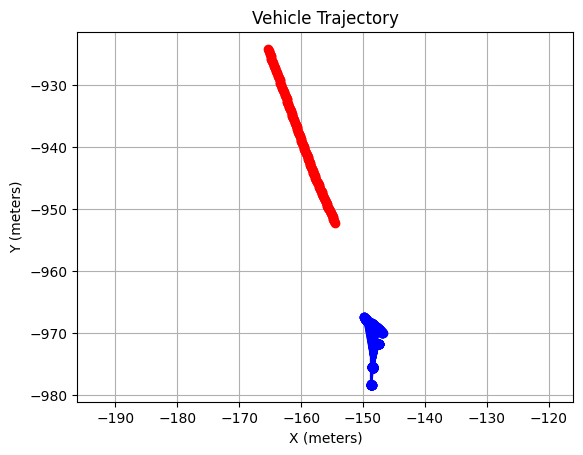

In [5]:
preprocessing.DrawTrack(ego_json=ego_data,pedestrian_json=neighbour_data)


In [8]:
results=[]
for pedestrian_dict in neighbour_data["Response"]:
    result={}
    ego_dict = get_data.GetCorrespondingEgoData(
        ego_vehicle_dataset=ego_data, pedestrian_data=pedestrian_dict
    )
    ego_inner = json.loads(ego_dict["Json"])
    pedestrian_inner = json.loads(pedestrian_dict["Json"])
    is_satisfied, conflict_point = preprocessing.ConflictPoint(
        ego_vehicle=ego_inner, pedestrian=pedestrian_inner
    )
    result["PedestrianId"]=pedestrian_inner["VehicleId"]
    result["Chid"]=pedestrian_dict["Chid"]
    print(is_satisfied)
    if is_satisfied==True:
        print(conflict_point.x,",",conflict_point.y)

True
-150.44268459782737 , -965.4001633577257
True
-151.0430923584626 , -963.772305276346
True
-150.62192548777858 , -964.9901055831252
True
-151.2624661137478 , -963.2672967778848
True
-150.91888774749262 , -964.3186989928247
True
-151.13970873051605 , -963.7677924641134
True
-151.31003531617262 , -963.2751313284375
True
-151.30462745577725 , -963.3508200581767
True
-151.61722472411006 , -962.5109089335667
True
-151.41811612431653 , -963.1162579852997
True
-151.04805585789816 , -964.1933996270099
True
-151.31536531476544 , -963.4562083203878
True
-147.82550777557051 , -973.3551926228723
True
-150.96292146802418 , -964.4766851198339
True
-147.91182998753933 , -973.1368785482305
True
-151.46298506141483 , -963.0671081769203
True
-147.8305672537929 , -973.3821597024931
True
-151.05419485618916 , -964.2213387377088
True
-147.47033270380123 , -974.3968326723947
True
-150.97135694869058 , -964.413300246287
True
-147.4126402680689 , -974.5018006247103
True
-150.56004076180625 , -965.42801942

In [1]:
import geojson
from shapely.geometry import shape, Point

with open("ca_martinez.geojson") as f:
    geo_data = geojson.load(f)

In [2]:
typenames = []
for feature in geo_data["features"]:
    geom = feature["geometry"]
    properties = feature["properties"]["type_names"]
    if not properties in typenames:
        typenames.append(properties)
print(typenames)

['Suppress Tracklets', 'Solid White', 'Solid Yellow', 'Assume Static', 'Lane Boundary', 'Border', 'Curb', 'Lane Nominal', 'Broken White', 'Broken Yellow', 'Advisory', 'Crossing', 'Pedestrian Crossing Region', 'Pedestrian Yield', 'Pedestrian Wait', 'Pedestrian Yield,Pedestrian Crossing Region', 'Broken White,Advisory', 'Pedestrian Wait,Pedestrian Crossing Region', 'Barrier', 'Solid Yellow,Solid White', 'Dotted White', 'Dotted Yellow']


In [4]:
import folium

filtered_features = [
    feature
    for feature in geo_data["features"]
    if feature["properties"]["type_names"] == "Crossing"
]
# creat a new geojson only including filtered features
filtered_geojson = {"type": "FeatureCollection", "features": filtered_features}
center = (38.0024795532, -122.126701355)
m = folium.Map(location=center, zoom_start=15)
folium.GeoJson(filtered_geojson, name="Lane Nominal").add_to(m)
m

In [18]:
point_coord = [-122.1330990851, 38.0183436246]
point = Point(point_coord)

min_d, closest_crossing = preprocessing.CalculateDistanceToCrossing(
    filtered_geojson, point
)

print(min_d)
print(closest_crossing)

3.1780206689052987e-07
{"geometry": {"coordinates": [[-122.133099, 38.018344, 0], [-122.133073, 38.018316, 0]], "type": "LineString"}, "properties": {"id": "1688173269450146", "is_node": false, "layer": 1, "left_lane_width": -1, "length": 3.79125397806511, "parent_id": "-1", "right_lane_width": -1, "source_id": "1688173269450136", "target_id": "1688173269450134", "type_mask": 549755813888, "type_names": "Crossing"}, "type": "Feature"}


In [22]:
# the parameter of Marker should be [latitude,longtitude]
point_reversed = [point_coord[1], point_coord[0]]
folium.Marker(
    point_reversed, popup="Point", icon=folium.Icon(color="red", icon="info-sign")
).add_to(m)
m